<a href="https://colab.research.google.com/github/Loinen/ml_labs/blob/main/ml_stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ПОСТРОЕНИЕ ПРЕДСКАЗАТЕЛЬНОЙ МОДЕЛИ ВОЗНИКНОВЕНИЯ ИНСУЛЬТА

В данной работе будет построена предсказательная модель возникновения инсульта на основе данных о [пациентах](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) c kaggle.

# 1. Загрузка данных и библиотек

In [276]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.model_selection as model_selection

%matplotlib inline

dataset = pd.read_csv("stroke_data.csv")
print(dataset.shape)


(5110, 12)


# 2. Анализ датасета

1.   id: уникальный идентификатор
2.   gender: Male, Female, Other
3.   age: возраст пациента
4.   hypertension: 0, если у пациента нет артериальной гипертензии, 1, если есть
5.   heart_disease: 0, если у пациента нет сердечных заболеваний, 1, если есть
6.   ever_married: No или Yes
7.   work_type: children, Govt_jov, Never_worked, Private или Self-employed - тип занятости
8.   Residence_type: Rural - Сельский или Urban - Городской
9.   avg_gluosis_level: средний уровень глюкозы в крови
10.  bmi: индекс массы тела
11.  smoking_status: статус курения - formerly smoked - «ранее курил», never smoked, smokes или Unknown
12.  stroke: 1, если у пациента был инсульт, или 0, если нет.


In [277]:
dataset.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [278]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [279]:
# print(dataset.value_counts("gender")) # f - 2994, m - 2115, other - 1
# print(dataset.value_counts("age"))
# print(dataset.value_counts("hypertension")) 0 - 4612, 1 - 498
# print(dataset.value_counts("heart_disease")) # 0 - 4834, 1 - 276
# print(dataset.value_counts("ever_married")) # y - 3353, n - 1757
# print(dataset.value_counts("work_type")) # Private - 2925, Self-employed - 819, children - 687, Govt_job - 657, Never_worked - 22
# print(dataset.value_counts("Residence_type")) #Urban - 2596, Rural - 2514
# print(dataset.value_counts("avg_glucose_level"))
# print(dataset.value_counts("bmi"))
# print(dataset.value_counts("smoking_status")) # never smoked - 1892, Unknown - 1544, formerly smoked - 885, smokes - 789
# print(dataset.value_counts("stroke")) # 0 - 4861, 1 - 249

In [280]:
child = dataset.loc[dataset['age'] <= 14]
print(child.value_counts("work_type")) 
# у нас есть достаточно много строк, где возраст явно с ошибками, но судя по worktype большинство из них дети
print(dataset.avg_glucose_level.loc[dataset['avg_glucose_level'] >= 260]) 
# avg gl - 70 mg/dl - 100 mg/dl  - normal, до 70 - hypoglycemia, от 100 до 125 - prediabetic, до 300 - diabetic

print(dataset['bmi'].loc[dataset['bmi'] >= 60]) 

# bmi = under_weight = 18.5, normal <24.9 overweight <29.9 obese 39.9
# у нас есть 13 человек с bmi больше 60 - это может быть вес от 135кг (если 150 см = 60 имт) до 200кг (181кг-150см = 78 имт), 
# теоретически, это могут быть выбросы. Низкие значения имт - в основном у детей, для них норма ниже

work_type
children         657
Private           29
Self-employed      6
Never_worked       6
Govt_job           1
dtype: int64
135     263.32
193     271.74
1207    267.76
2462    266.59
3088    267.61
3215    260.85
3393    263.56
4457    261.67
4983    267.60
Name: avg_glucose_level, dtype: float64
270     60.9
358     64.8
466     60.2
544     71.9
928     78.0
1559    66.8
2128    97.6
2764    63.3
2840    61.2
3825    61.6
4188    64.4
4209    92.0
4838    60.9
Name: bmi, dtype: float64


# 3. Предобработка данных
Видно, что у нас есть пропуски в bmi, а также есть пациенты, у которых неизвестен статус курения. Необходимо обработать эти значения, а также категориальные признаки - age, smoking_status, work_type.
Бинарные признаки - hypertension, heart_disease, Residence_type, ever_married, gender (other всего один, можно его отбросить).
Столбец id отбросим. 
Признаки age, work_type, avg_glucose_level, bmi можно преобразовать. Для bmi можно обозначить норму, неизвестный статус и превышение нормы. Желательно, чтобы в обучающую выборку попали хотя бы несколько пациентов, у которых есть статус Never_worked, а также обязательно - часть тех, у кого был инсульт и хотя бы немного с 0 для heart_disease и hypertension




stroke (249, 12) no_stroke (4861, 12)


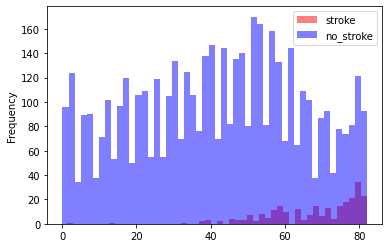

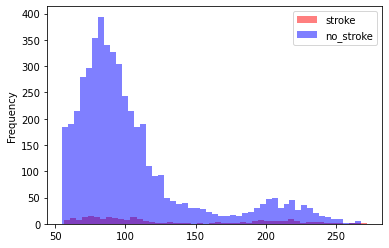

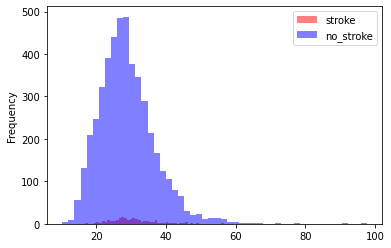

In [281]:
stroke = dataset[dataset.stroke == 1]
no_stroke = dataset[dataset.stroke == 0]
print("stroke", stroke.shape, "no_stroke", no_stroke.shape)

stroke["age"].plot.hist(alpha=0.5,color='red',bins=50)
no_stroke["age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['stroke','no_stroke'])
plt.show()

stroke["avg_glucose_level"].plot.hist(alpha=0.5,color='red',bins=50)
no_stroke["avg_glucose_level"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['stroke','no_stroke'])
plt.show()

stroke["bmi"].plot.hist(alpha=0.5,color='red',bins=50)
no_stroke["bmi"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['stroke','no_stroke'])
plt.show()

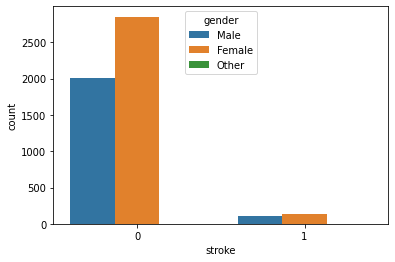

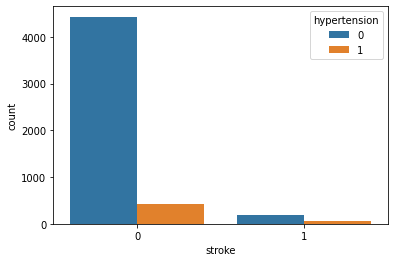

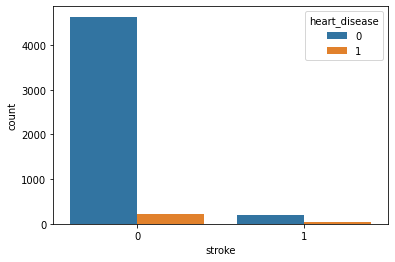

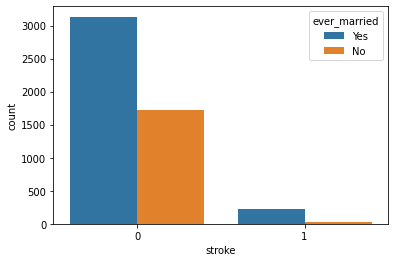

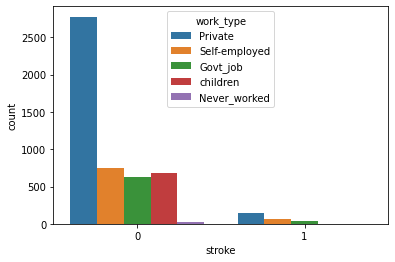

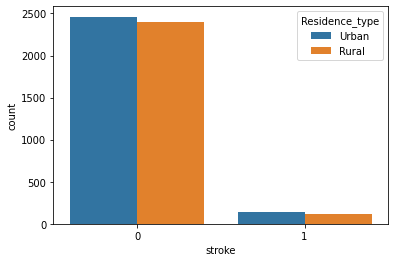

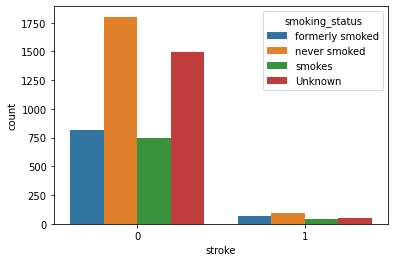

In [282]:
sns.countplot(x="stroke",data=dataset,hue='gender')
plt.show()
sns.countplot(x="stroke",data=dataset,hue='hypertension')
plt.show()
sns.countplot(x="stroke",data=dataset,hue='heart_disease')
plt.show()
sns.countplot(x="stroke",data=dataset,hue='ever_married')
plt.show()
sns.countplot(x="stroke",data=dataset,hue='work_type')
plt.show()
sns.countplot(x="stroke",data=dataset,hue='Residence_type')
plt.show()
sns.countplot(x="stroke",data=dataset,hue='smoking_status')

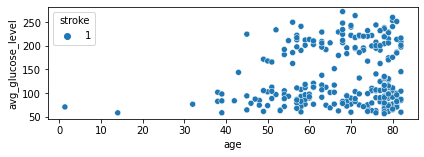

In [283]:
plt.subplot(2,1,2)
sns.scatterplot(x=stroke['age'],y=stroke['avg_glucose_level'],hue=stroke['stroke'])
plt.tight_layout()
plt.show()

(5110, 12)
gender
Female    2994
Male      2115
dtype: int64
(5109, 12)


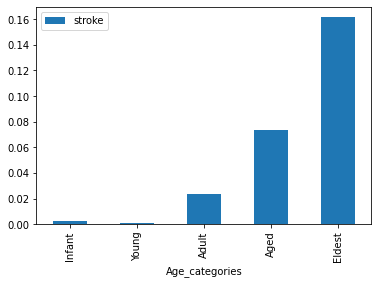

In [284]:
# Удалим лишнего пациента с "другим" полом 
print(dataset.shape)
dataset = dataset.drop(np.where(dataset['gender'] == "Other")[0])
print(dataset.value_counts("gender"))
print(dataset.shape)

# Преобразуем возраст в категориальный признак. 
def process_age(df, cut_points, label_names):
    df['age'] = df['age'].replace(np.NaN, -0.5) #fillna
    df['Age_categories'] = pd.cut(df['age'], bins=cut_points, labels=label_names)
    return df

# Нас в основном интересуют пациенты с возрастом от 35-55 до 80. 
cut_points = [0, 18, 35, 55, 65, 100]
label_names = ["Infant", "Young", "Adult", "Aged", "Eldest"]
dataset = process_age(dataset, cut_points, label_names)

age_cat_pivot = dataset.pivot_table(index="Age_categories",values="stroke")
age_cat_pivot.plot.bar()
plt.show()

In [285]:
def create_dummies(df, column_name):
    dum = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df,dum],axis=1)
    return df

dataset = create_dummies(dataset, "hypertension")
dataset = create_dummies(dataset, "heart_disease")
dataset = create_dummies(dataset, "Residence_type")
dataset = create_dummies(dataset, "ever_married")
dataset = create_dummies(dataset, "gender")

dataset = create_dummies(dataset, "work_type")
dataset = create_dummies(dataset, "smoking_status")
dataset = create_dummies(dataset, "Age_categories")

In [286]:
miss_bmi = dataset[dataset.bmi.isna()]
print("missing:", len(miss_bmi))
print("missing with stroke:", len(miss_bmi[miss_bmi.stroke == 1]))
print("В наборе данных у 40 из 249 пациентов с инсультом неизвестен ИМТ")

missing: 201
missing with stroke: 40
В наборе данных у 40 из 249 пациентов с инсультом неизвестен ИМТ


In [288]:
# пробуем предсказать имт, вместо медианы\среднего
data = dataset.copy()
data = data[~data.bmi.isna()]
print(data.shape)
y = data['bmi']

data = data[['hypertension', 'avg_glucose_level',  'Residence_type_Rural', 
             'Residence_type_Urban', 'gender_Female', 'gender_Male', 'work_type_children', 
            'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult', 'Age_categories_Aged', 'Age_categories_Eldest']]

(4908, 37)


In [290]:
from sklearn.ensemble import GradientBoostingRegressor

# у нас всего 249 пациентов с инсультом из 5к. все они находятся в начале датасета
x_train, x_test, y_train, y_test = train_test_split(data, y, train_size=0.8, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape) 

model = Pipeline( steps=[ ('scale',StandardScaler()),
                          ('lr',GradientBoostingRegressor(random_state=42))])
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Предсказанные значения:\n', np.around(list(y_pred[:50]), 1))
print('Истинные значения:\n', np.around(list(y_test[:50]), 1))

(3926, 12) (982, 12) (3926,) (982,)
Предсказанные значения:
 [29.4 30.6 29.9 29.  31.  28.2 29.4 28.4 30.4 25.6 29.3 28.6 30.7 29.
 30.2 39.8 28.8 29.5 30.9 31.  31.  31.  34.8 31.1 30.4 30.7 30.1 26.3
 27.7 29.1 33.5 29.  32.8 29.  19.7 29.9 29.9 30.8 31.9 30.6 30.6 32.6
 20.3 29.7 19.7 29.5 20.1 29.9 29.  29. ]
Истинные значения:
 [32.3 31.4 32.1 25.3 22.2 20.1 23.2 30.3 24.8 21.2 32.  24.4 26.4 16.9
 30.5 35.1 23.6 35.3 32.4 22.7 23.1 24.1 38.9 39.1 17.3 33.7 37.7 22.6
 36.4 29.2 28.4 28.4 24.6 46.5 18.4 35.5 27.9 21.5 24.1 44.  28.1 37.4
 27.5 52.8 20.5 29.6 18.6 37.  41.3 43. ]


In [291]:
from sklearn.metrics import accuracy_score, r2_score

train = pd.concat([x_train,y_train],axis=1)
test = pd.concat([x_test,y_test],axis=1)
y_pred = test.copy()

bmi_mean = np.mean(train['bmi'])
y_pred['bmi'] = bmi_mean
print('Model score:', model.score(x_test, y_test))
print('Mean score: ', r2_score(y_test, y_pred.bmi))
# видно, что модель дает хоть и не очень точные, но достаточно качественные значения, в отличие от усреднения

Model score: 0.2431073052054895
Mean score:  -0.0011478514902276693


In [293]:
# Теперь предскажем имт для NAN
model = Pipeline( steps=[ ('scale',StandardScaler()),
                          ('lr',GradientBoostingRegressor(random_state=42))])
model.fit(data, y)

X = miss_bmi[['age', 'hypertension', 'avg_glucose_level', 'Residence_type_Rural', 
             'Residence_type_Urban', 'gender_Female', 'gender_Male', 'work_type_children', 
             'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult', 'Age_categories_Aged']]
y_pred = model.predict(X)
dataset = dataset.copy()
dataset.loc[miss_bmi.index,'bmi'] = pd.Series(y_pred,index=miss_bmi.index)

 # 4. Примените различные преобразования признаков (`PolynomialFeatures`).

In [ ]:
# tpoly = PolynomialFeatures(degree=3, interaction_only=True)
# tpoly3 = tpoly.fit_transform(train)
# fpoly = PolynomialFeatures(degree=3, interaction_only=False)
# fpoly3 = fpoly.fit_transform(train)

__Задание 5.__  
Обучите несколько классификаторов, в том числе:  
1. Логистическую регрессию (`LogisticRegression`).
1. Метод опорных векторов (`SVC`).
1. Метод *k* ближайших соседей (`KNeighborsClassifier`).
1. Наивный байесовский классификатор (`MultinomialNB`).
1. Деревья решений (`DecisionTreeClassifier`).
1. Случайный лес (`RandomForestClassifier`).
1. AdaBoost (`AdaBoost`).
1. Градиентный бустинг (`GradientBoostingClassifier`).

Для обучения и проверки качества можно использовать функцию `train_test_split()`.

In [310]:
from sklearn.model_selection import StratifiedShuffleSplit
# Разделим на тестовую, валидационную и обучающие выборки 
print(dataset.columns)
drop_cols = ['id', "hypertension", "heart_disease", "Residence_type", 
            'ever_married', 'ever_married_No','ever_married_Yes',
             "gender", "smoking_status", 
             'Residence_type_Rural', 'Residence_type_Urban',
             "work_type", # 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed',
             "age", "Age_categories",  
             'heart_disease_0', 'heart_disease_1',
             'stroke'] 
y = dataset['stroke']
X = dataset.copy()
X = dataset[['gender_Female', 'gender_Male',"hypertension", "heart_disease", 'avg_glucose_level','bmi','Age_categories_Infant',
       'Age_categories_Young', 'Age_categories_Adult', 'Age_categories_Aged',
       'Age_categories_Eldest']] #X.drop(columns=drop_cols, axis=1)

sss = StratifiedShuffleSplit(n_splits=4, train_size=0.8, random_state=42)
sss.get_n_splits(X, y)
print(sss)
for train_index, test_index in sss.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(y_train.value_counts(), y_test.value_counts()) # Видим, что распределение классов сохранено

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'Age_categories', 'hypertension_0',
       'hypertension_1', 'heart_disease_0', 'heart_disease_1',
       'Residence_type_Rural', 'Residence_type_Urban', 'ever_married_No',
       'ever_married_Yes', 'gender_Female', 'gender_Male',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult',
       'Age_categories_Aged', 'Age_categories_Eldest'],
      dtype='object')
StratifiedShuffleSplit(n_splits=4, random_state=42, test_size=None,
            train_size=0.8)
0    3888
1     199
Name: stroke, dtype: int64 0    972
1     50
Name: s

__Задание 6.__  
При помощи `Pipeline` и `GridSearchCV` выберите оптимальную архитектуру:
1. Метод масштабирования.
1. Степень полинома в `PolynomialFeatures`.
1. Параметры классификаторов (в том числе, параметры регуляризации).

Заносите в таблицу Excel результаты тестирования (варианты параметров, оценки качества).

In [ ]:
classifiers = [
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

# LogisticRegression()
params1 = {"poly__degree": range(1,2,1), "clf__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
           "clf__max_iter": [1200,1300]} # range start stop step
# SVC
params2 = {"poly__degree": range(1,2,1),"clf__kernel":["rbf", "poly", "linear", "sigmoid"], "clf__gamma": ["auto", "scale"], 
           "clf__degree":range(1,6,1)}
# KNeighborsClassifier()
params3 = {"poly__degree": range(1,2,1),"clf__n_neighbors": range(4,10,1), "clf__weights": ["uniform", "distance"],
         "clf__algorithm": ['ball_tree', 'kd_tree']}
# MultinomialNB()
params4 = {"poly__degree": range(1,2,1),"clf__fit_prior": ['True', 'False'], "clf__alpha": np.arange(0.8,1.2,0.1)}
# DecisionTreeClassifier()
params5 = {"poly__degree": range(1,2,1),"clf__criterion":["gini", "entropy"], "clf__max_depth": range(5,16,1), "clf__min_samples_split": range(2,8,1),
           "clf__min_samples_leaf": range(1,5,1)}   
# RandomForestClassifier()
params6 = {"poly__degree": range(1,2,1),"clf__criterion":["gini", "entropy"], "clf__class_weight":["balanced", "balanced_subsample"], 
           "clf__max_depth": range(4,10,2), "clf__min_samples_leaf": range(5,11,2), "clf__n_estimators":range(50,150,50)} 
# AdaBoostClassifier()
params7 = {"poly__degree": range(1,2,1),"clf__learning_rate":np.arange(0.2,0.6,0.1), "clf__n_estimators":range(20,60,20),
         "clf__algorithm":["SAMME", "SAMME.R"]} 
# GradientBoostingClassifier()
params8 = {"poly__degree": range(1,2,1),"clf__loss":["deviance", "exponential"], 
           "clf__learning_rate":[0.09,0.085,0.1], "clf__n_estimators":range(80,120,20),
           "clf__min_samples_leaf": range(1,4,1), "clf__max_depth": range(5,15,1), 
           #"clf__max_features": ["auto", "sqrt", "log2"], "clf__validation_fraction":np.arange(0.01,0.2,0.05)
           }

parameters = [params1, params2, params3, params4, params5, params6, params7, params8]
i = 0
for classifier in classifiers:
    print(classifier)
    pipe = Pipeline(steps=[('scaler', MinMaxScaler()), #MinMaxScaler() StandardScaler()
                            ('poly', PolynomialFeatures()),
                            ('clf', classifier) # , return_train_score = True
                      ])
    # выбираем balanced_accuracy, а не accuracy, так как классы несбалансированы
    grid_cv = model_selection.GridSearchCV(pipe, parameters[i], scoring='f1') 
    grid_cv.fit(x_train, y_train)
    print("model best f1 score: ", grid_cv.best_score_)    
    print(grid_cv.best_params_)
    model = grid_cv.best_estimator_
    print("model test score: ", model.score(x_test, y_test))
    i+=1

In [311]:
# RandomForestClassifier()
rfc = {"clf__criterion":["gini", "entropy"], "clf__class_weight":["balanced", "balanced_subsample"], 
           "clf__max_depth": range(6,12,2), "clf__min_samples_leaf": range(5,9,1), "clf__n_estimators":[50,100]} 
pipe = Pipeline(steps=[     ('scaler', MinMaxScaler()), #MinMaxScaler() StandardScaler()
                            ('poly', PolynomialFeatures()),
                            ('clf', RandomForestClassifier()) 
                      ])
grid_cv = model_selection.GridSearchCV(pipe, rfc, scoring='f1')
grid_cv.fit(x_train, y_train)
print("model best score: ", grid_cv.best_score_)    
print(grid_cv.best_params_)
model = grid_cv.best_estimator_

model best score:  0.2634665492426058
{'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_leaf': 8, 'clf__n_estimators': 50}


In [312]:
y_pred = model.predict(x_test)

In [313]:
# посмотрим, какие случаи не предсказала угадала модель
real = pd.concat([x_test, y_test], axis=1)
pred = real.copy()
pred["stroke2"] = y_pred
print(pred.shape, real.shape)

pred = pd.concat([real, pred.stroke2], axis=1)
real = real[real.stroke == 1]
pred = pred[pred.stroke2 == 1]
print(pred.shape)

(1022, 13) (1022, 12)
(207, 13)


In [317]:
pd.options.display.max_rows = 210
pred # 156

,gender_Female,gender_Male,hypertension,heart_disease,avg_glucose_level,bmi,Age_categories_Infant,Age_categories_Young,Age_categories_Adult,Age_categories_Aged,Age_categories_Eldest,stroke,stroke2
1309,0,1,0,1,181.23,32.200000,0,0,0,0,1,0,1
1529,1,0,0,0,253.16,47.500000,0,0,0,0,1,0,1
724,0,1,0,0,64.41,29.400000,0,0,0,0,1,0,1
4411,0,1,0,1,112.37,28.400000,0,0,0,1,0,0,1
475,1,0,0,0,69.01,32.600000,0,0,0,0,1,0,1
2318,1,0,1,0,173.96,31.200000,0,0,1,0,0,0,1
3548,0,1,0,0,192.47,30.300000,0,0,0,1,0,0,1
303,0,1,0,0,242.30,35.300000,0,0,0,0,1,0,1
1655,1,0,0,0,222.60,40.100000,0,0,0,1,0,0,1
1083,1,0,0,0,89.45,30.300000,0,0,0,0,1,0,1


In [315]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Bar(x=x_test.columns,y = model['clf'].feature_importances_))
fig.update_layout(title='The Importance Of The Original Attributes On Our Prediction',xaxis_title='Model',yaxis_title='F1 Score')
fig.show()

In [316]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       815
           1       0.62      0.15      0.24       207

    accuracy                           0.81      1022
   macro avg       0.72      0.56      0.57      1022
weighted avg       0.78      0.81      0.76      1022



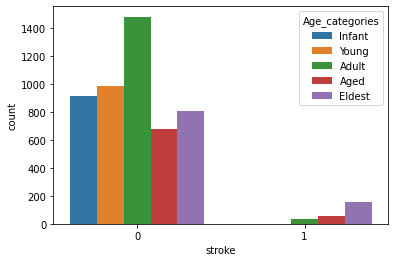

In [302]:
sns.countplot(x="stroke",data=dataset,hue='Age_categories')